In [1]:
import sys
sys.path.append('/home/599/dbi599/unseen/unseen')
import glob

import dask
from dask.distributed import Client, LocalCluster
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

import fileio
import spatial_selection

In [2]:
dask.config.set(temporary_directory='/g/data/xv83/dbi599')
cluster = LocalCluster(n_workers=1, threads_per_worker=1)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:34879 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 44.92 GiB


In [3]:
cafe_files = glob.glob('/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-??[9,0,1,2]*/atmos_isobaric_daily.zarr.zip')
cafe_files.sort()
print(cafe_files[0])
print(cafe_files[-1])

/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-19900501/atmos_isobaric_daily.zarr.zip
/g/data/xv83/dcfp/CAFE-f6/c5-d60-pX-f6-20201101/atmos_isobaric_daily.zarr.zip


In [4]:
ds_tasmax = fileio.open_mfzarr(cafe_files,
                               variables=['tasmax'],
                               metadata_file='../config/dataset_cafe_daily.yml',
                               units={'tasmax': 'C'},
                               spatial_coords=[47.45, -122.31 + 360])

In [6]:
argmax = ds_tasmax['tasmax'].argmax(dim=['ensemble', 'time'])

In [10]:
argmax['ensemble'].compute()

distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


<xarray.DataArray 'tasmax' ()>
array(6)

In [11]:
argmax['time'].compute()

<xarray.DataArray 'tasmax' ()>
array(41898)

In [13]:
ds_tasmax.isel({'ensemble': 6, 'time': 41898}).compute()

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    ensemble  int64 7
    time      object 2000-07-16 12:00:00
Data variables:
    tasmax    float32 46.1
Attributes:
    comment:    pressure level interpolator, version 3.0, precision=double
    filename:   atmos_isobaric_daily.zarr
    grid_tile:  N/A
    grid_type:  regular
    title:      AccessOcean-AM2

In [5]:
ds = fileio.open_mfzarr(cafe_files,
                        variables=['h500', 'tasmax'],
                        units={'tasmax': 'C'},
                        metadata_file='../config/dataset_cafe_daily.yml',
                        )

distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


In [7]:
ds

,Array,Chunk
Bytes,1.02 TiB,132.89 MiB
Shape,"(226456, 96, 90, 144)","(28, 96, 90, 144)"
Count,16306 Tasks,8122 Chunks
Type,float32,numpy.ndarray


In [6]:
ds_max = ds.isel({'ensemble': 6, 'time': 41898})

In [32]:
#def plot_global(da_gh500):
#    """Global plot"""
#
#    fig = plt.figure(figsize=[12,5])
#    map_proj = ccrs.PlateCarree()
#
#    ax = fig.add_subplot(111, projection=map_proj)
#    da_gh500.plot.contourf(ax=ax,
#                           transform=ccrs.PlateCarree(),
#                           levels=np.arange(5200, 6150, 50),
#                           )
#    ax.plot(-122.31, 47.45, 'ro', transform=ccrs.PlateCarree())
#    ax.coastlines()
#    ax.gridlines(linestyle='--')
#    plt.show()
#    
#    
def plot_usa(ds):
    """USA plot"""
    
    fig = plt.figure(figsize=[12,5])
    map_proj = ccrs.LambertConformal(central_longitude=262.5, central_latitude=38.5, standard_parallels=[38.5, 38.5])
    h500_levels = np.arange(5200, 6150, 50)
    
    ax = fig.add_subplot(111, projection=map_proj)
    
    ds['tasmax'].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.cm.hot_r, vmin=10, vmax=50)
    
    lines = ds['h500'].plot.contour(ax=ax,
                                    transform=ccrs.PlateCarree(),
                                    levels=h500_levels,
                                    colors=['brown'])
    ax.clabel(lines, colors=['brown'], manual=False, inline=True)
        
    ax.plot(-122.31 + 360, 47.45, 'bo', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([-140, -60, 20, 70])
    ax.gridlines(linestyle='--')
    plt.show()

In [ ]:
plot_usa(ds_max)

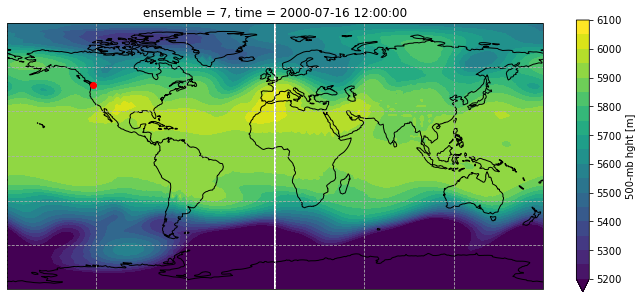

In [33]:
plot_global(ds_max['h500'])

TODO: Check that this isn't 180 degrees of longitude out of phase by plotting a variable with a more distinct spatial pattern (e.g. surface temperature or rainfall).

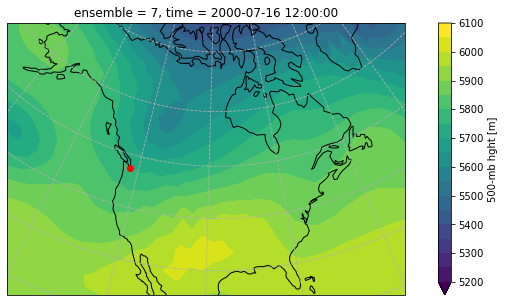

In [34]:
plot_usa(ds_max['h500'])

In [7]:
#filtered = ds[ds_tasmax['tasmax'] > 42.2]

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


TypeError: unhashable type: 'numpy.ndarray'

In [6]:
filtered = ds.where(ds_tasmax['tasmax'] > 42.2)

distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


In [7]:
filtered

,Array,Chunk
Bytes,1.02 TiB,132.89 MiB
Shape,"(226456, 96, 90, 144)","(28, 96, 90, 144)"
Count,89466 Tasks,8122 Chunks
Type,float32,numpy.ndarray


In [8]:
composite = filtered.mean(['ensemble', 'time'])

In [9]:
composite

<xarray.Dataset>
Dimensions:  (lat: 90, lon: 144)
Coordinates:
  * lat      (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
  * lon      (lon) float64 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
Data variables:
    h500     (lat, lon) float32 dask.array<chunksize=(90, 144), meta=np.ndarray>

In [10]:
composite = composite.compute()

distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


In [11]:
plot_usa(composite)

NameError: name 'plot_usa' is not defined

## JRA-55

In [36]:
ds_jra = xr.open_dataset('/g/data/xv83/dbi599/seatac/anl_p125.007_hgt.2021060100_2021063018', engine='cfgrib')

In [37]:
ds_jra_max = ds_jra.sel({'time': '2021-06-28', 'isobaricInhPa': 500}).mean('time')

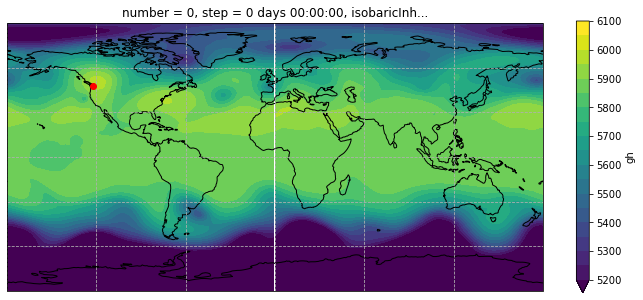

In [38]:
plot_global(ds_jra_max['gh'])

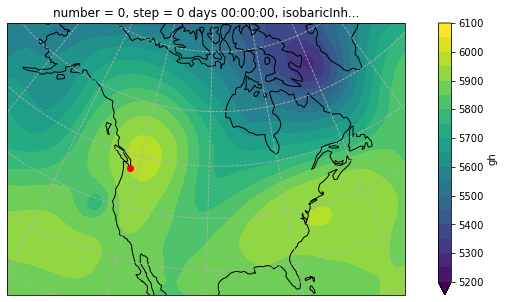

In [39]:
plot_usa(ds_jra_max['gh'])